## Import modules

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scrublet as scr
import session_info

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
session_info.show()

## Functions

## Read in anndata

In [3]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/QC/multiome_RNA_foetal_prefilter.h5ad')
adata

AnnData object with n_obs × n_vars = 487347 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-17', 'ambient_expression-18', 'ambient_expression-19', 'ambient_expression-2', 'ambient_expression-20', 'ambient_expression-21', 'ambient_expression-22', 'ambient_expression-23', 'ambient_expression-24', 'ambient_expression-25', 'ambient_expression-26', 'ambient_expression-27', 'ambient_expression-28', 'ambient_expression-29', 'ambient

In [4]:
adata.obs['combinedID'].value_counts()

BHF_F_Hea13188316_BHF_F_Hea13187618    59866
BHF_F_Hea11933665_BHF_F_Hea11596618    33997
BHF_F_Hea13188318_BHF_F_Hea13187620    27856
BHF_F_Hea13168898_BHF_F_Hea13168514    24781
BHF_F_Hea13188324_BHF_F_Hea13187626    24381
BHF_F_Hea13168896_BHF_F_Hea13168512    22267
BHF_F_Hea11933666_BHF_F_Hea11596619    21509
BHF_F_Hea13168899_BHF_F_Hea13168515    21418
BHF_F_Hea13188317_BHF_F_Hea13187619    21327
BHF_F_Hea11933664_BHF_F_Hea11596617    20338
BHF_F_Hea11933667_BHF_F_Hea11596620    19811
BHF_F_Hea13168894_BHF_F_Hea13168510    19258
BHF_F_Hea11933669_BHF_F_Hea11596622    19029
BHF_F_Hea13168897_BHF_F_Hea13168513    18609
BHF_F_Hea13168895_BHF_F_Hea13168511    18315
BHF_F_Hea11933668_BHF_F_Hea11596621    17494
BHF_F_Hea13168893_BHF_F_Hea13168509    11782
BHF_F_Hea11933670_BHF_F_Hea11596623    11068
BHF_F_Hea11933673_BHF_F_Hea11596626    10769
BHF_F_Hea11933671_BHF_F_Hea11596624    10256
BHF_F_Hea11064672_BHF_F_Hea11031825    10191
BHF_F_Hea13168892_BHF_F_Hea13168508    10023
BHF_F_Hea1

## Remove doublets

<AxesSubplot:>

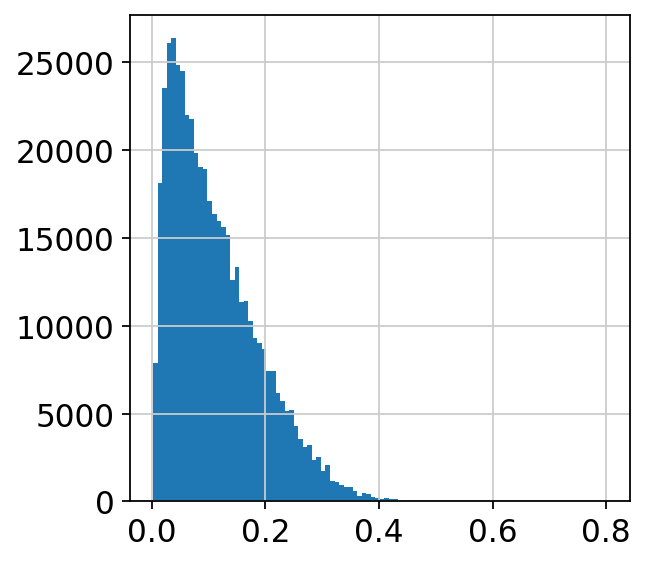

In [5]:
adata.obs['scrublet_score'].hist(bins=100)

In [6]:
# set threshold (arbitrary)
dbl_score_thresh=0.15

prop = np.sum(adata.obs['scrublet_score']>=dbl_score_thresh)/len(adata)
print(f'proportion of doublets: {prop}')

proportion of doublets: 0.27659757831688714


In [7]:
# Save doublet ids
doublets = adata.obs_names[(adata.obs['scrublet_score']<dbl_score_thresh)==False]
with open('/nfs/team205/heart/anndata_objects/Foetal/QC/Multiome_rm-doublets.txt', 'w') as f:
    for line in doublets:
        f.write(line)
        f.write('\n')

# Remove doublets
adata = adata[adata.obs['scrublet_score']<dbl_score_thresh]
adata

View of AnnData object with n_obs × n_vars = 352548 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-17', 'ambient_expression-18', 'ambient_expression-19', 'ambient_expression-2', 'ambient_expression-20', 'ambient_expression-21', 'ambient_expression-22', 'ambient_expression-23', 'ambient_expression-24', 'ambient_expression-25', 'ambient_expression-26', 'ambient_expression-27', 'ambient_expression-28', 'ambient_expression-29', 

## Remove low quality cells

In [8]:
sc.pp.filter_cells(adata, min_genes=500, inplace=True)
sc.pp.filter_cells(adata, min_counts=1000, inplace=True)
adata.shape

filtered out 45375 cells that have less than 500 genes expressed
Trying to set attribute `.obs` of view, copying.
filtered out 19178 cells that have less than 1000 counts


(287995, 36601)

In [9]:
adata.obs['sangerID'].value_counts()

BHF_F_Hea13188316    38238
BHF_F_Hea13188318    15285
BHF_F_Hea13168898    15004
BHF_F_Hea13188324    14745
BHF_F_Hea11933665    13987
BHF_F_Hea13168899    13569
BHF_F_Hea13168896    13183
BHF_F_Hea11933664    12869
BHF_F_Hea13188317    12775
BHF_F_Hea11933666    12594
BHF_F_Hea11933667    12288
BHF_F_Hea13168894    12277
BHF_F_Hea13168895    11522
BHF_F_Hea11933669    11379
BHF_F_Hea11933668    11018
BHF_F_Hea13168897    10979
BHF_F_Hea13168893     7118
BHF_F_Hea11933673     6463
BHF_F_Hea11933671     6051
BHF_F_Hea13168892     5905
BHF_F_Hea11933672     5901
BHF_F_Hea11064672     5623
BHF_F_Hea11933670     5529
BHF_F_Hea11933674     3815
BHF_F_Hea13188328     3273
BHF_F_Hea11064671     2955
BHF_F_Hea13188329     1280
BHF_F_Hea13188330     1150
BHF_F_Hea11064670      737
BHF_F_Hea11933675      483
Name: sangerID, dtype: int64

## Compute QC stats

In [10]:
adata.var['mt'] = adata.var['gene_name'].str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var['gene_name'].str.startswith('RPS','RPL')  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=True, inplace=True)

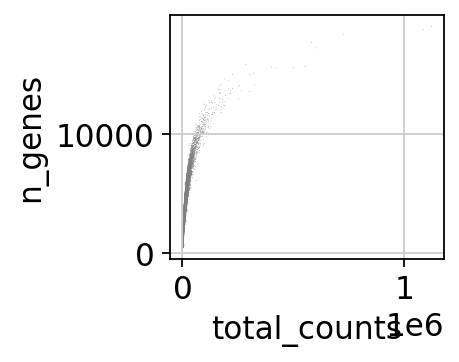

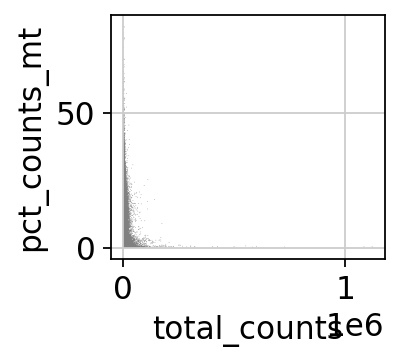

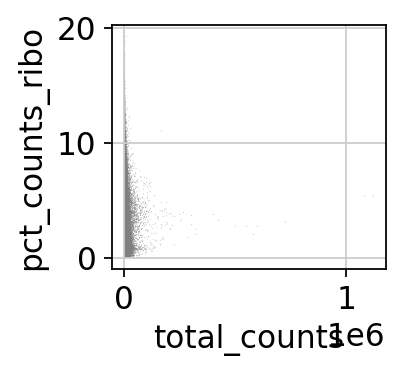

In [11]:
plt.rcParams['figure.figsize'] = [3, 2]

sc.pl.scatter(adata, x='total_counts', y='n_genes')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo')

## Remove cells exceeding the ribo/mito threshold

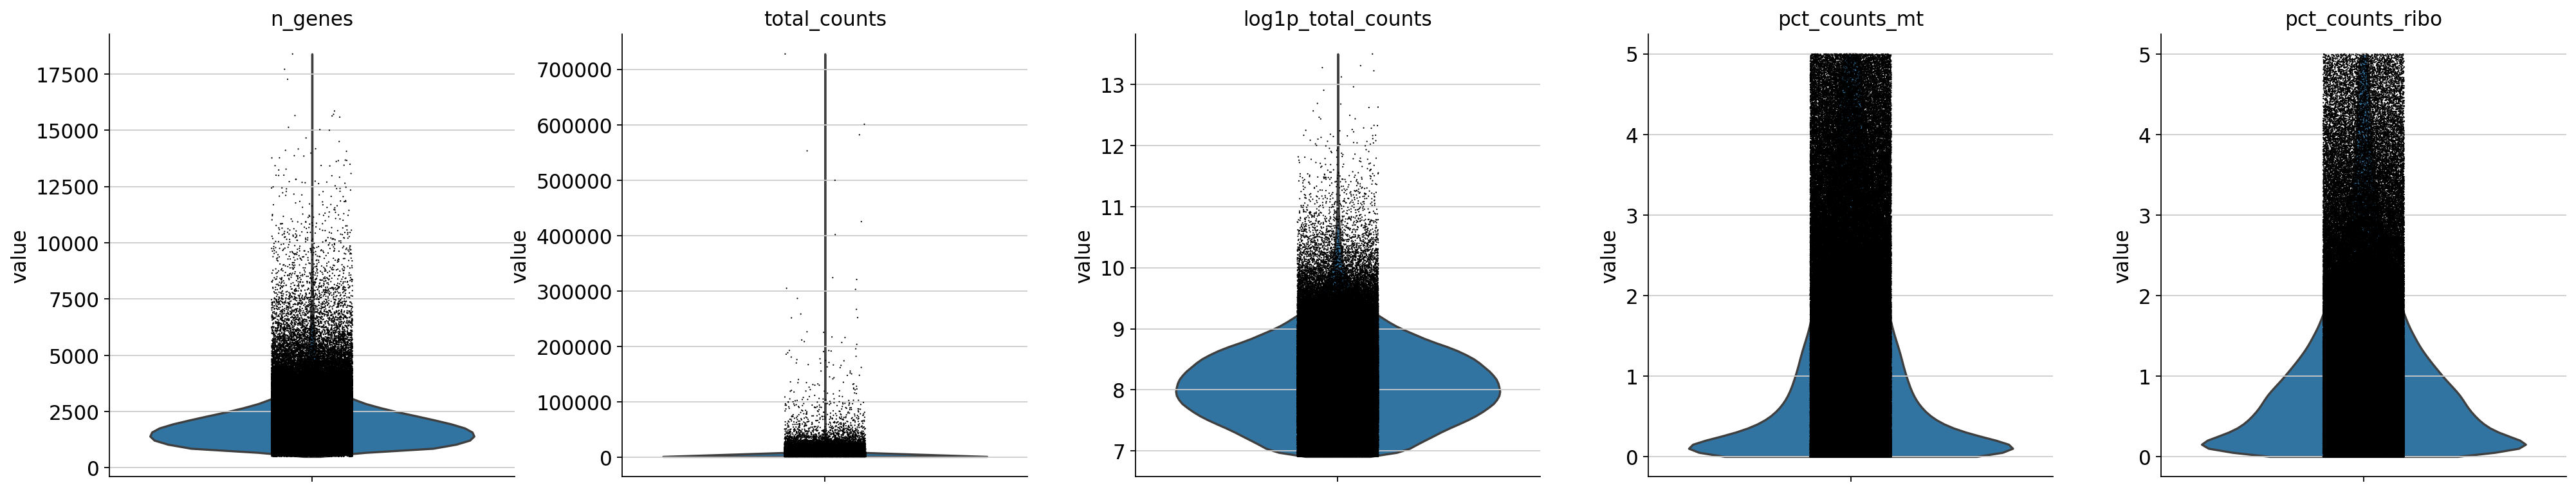

In [12]:
plt.rcParams['figure.figsize'] = [2, 2]
adata = adata[adata.obs['pct_counts_mt'] < 5, :]
adata = adata[adata.obs['pct_counts_ribo'] < 5, :]
sc.pl.violin(adata, ['n_genes', 'total_counts', 'log1p_total_counts','pct_counts_mt', 'pct_counts_ribo'],jitter = 0.1, multi_panel = True)

Trying to set attribute `.uns` of view, copying.


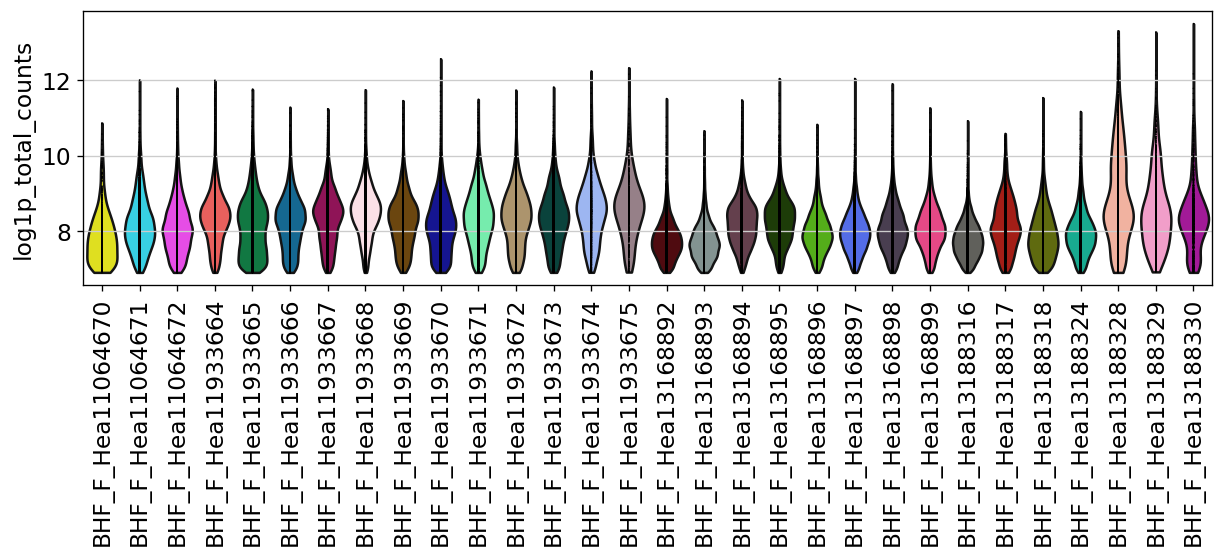

In [13]:
sc.settings.set_figure_params(dpi = 120, color_map = 'RdPu')
plt.rcParams['figure.figsize'] = 10,3
sc.pl.violin(adata,keys=['log1p_total_counts'],groupby='sangerID',rotation=90,jitter=False)

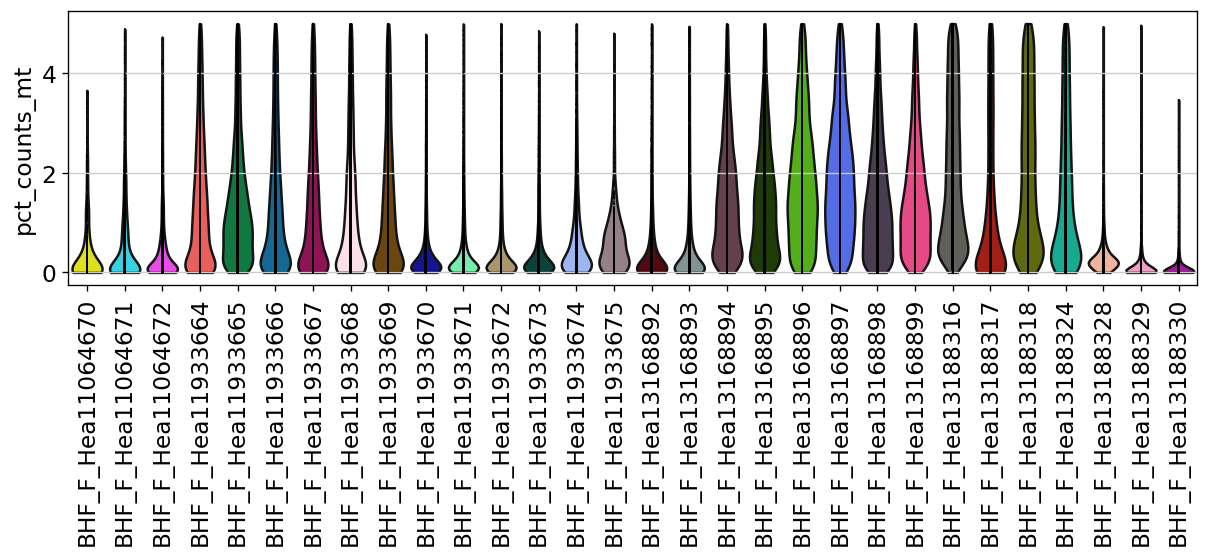

In [14]:
plt.rcParams['figure.figsize'] = 10,3
sc.pl.violin(adata,keys=['pct_counts_mt'],groupby='sangerID',rotation=90,jitter=False)

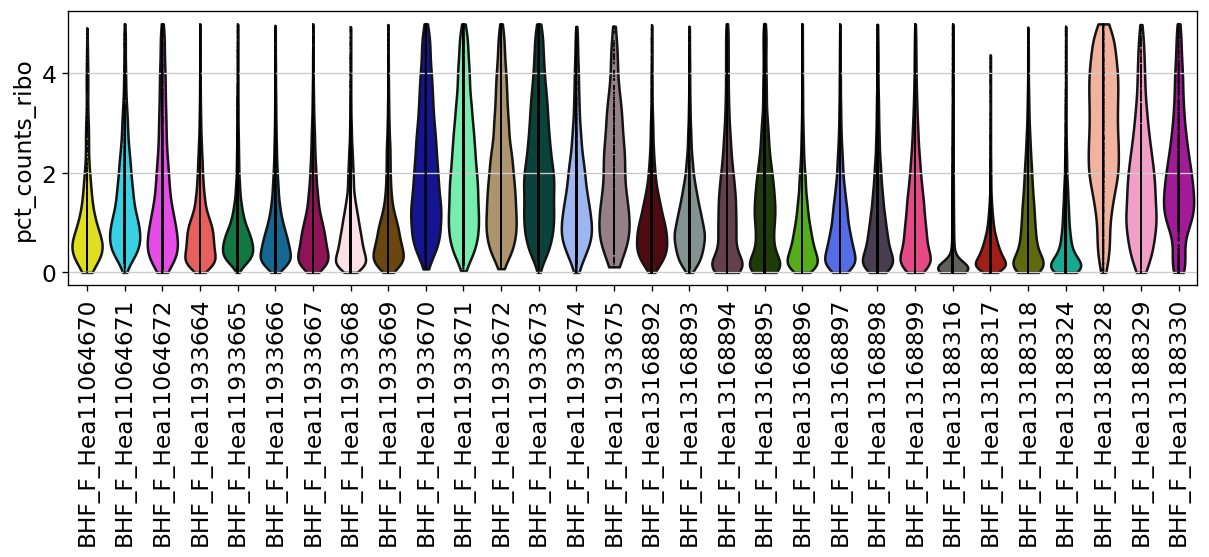

In [15]:
plt.rcParams['figure.figsize'] = 10,3
sc.pl.violin(adata,keys=['pct_counts_ribo'],groupby='sangerID',rotation=90,jitter=False)

In [16]:
sc.settings.set_figure_params(dpi = 120, color_map = 'RdPu')

In [17]:
adata.shape

(222061, 36601)

## Calculate RBC score 

In [18]:
adata_c = adata.copy()

adata_c.var.set_index('gene_name',inplace=True)
adata_c.var_names = adata_c.var_names.astype('str')
adata_c.var_names_make_unique()

sc.pp.filter_genes(adata_c, min_cells=3)
sc.pp.normalize_total(adata_c, target_sum=1e4)
sc.pp.log1p(adata_c)

filtered out 2139 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:02)


In [19]:
# scoring hemoglobin genes
# HGNC, Hemoglobin subunits, groupID:940
genes=['HBA1','HBA2','HBB','HBD','HBE1','HBG1','HBG2','HBM','HBQ1','HBZ']
sc.tl.score_genes(adata_c,gene_list=genes,score_name='HB_score')

computing score 'HB_score'
    finished: added
    'HB_score', score of gene set (adata.obs).
    400 total control genes are used. (0:00:07)


In [20]:
len(adata_c.obs['sangerID'].unique())

30

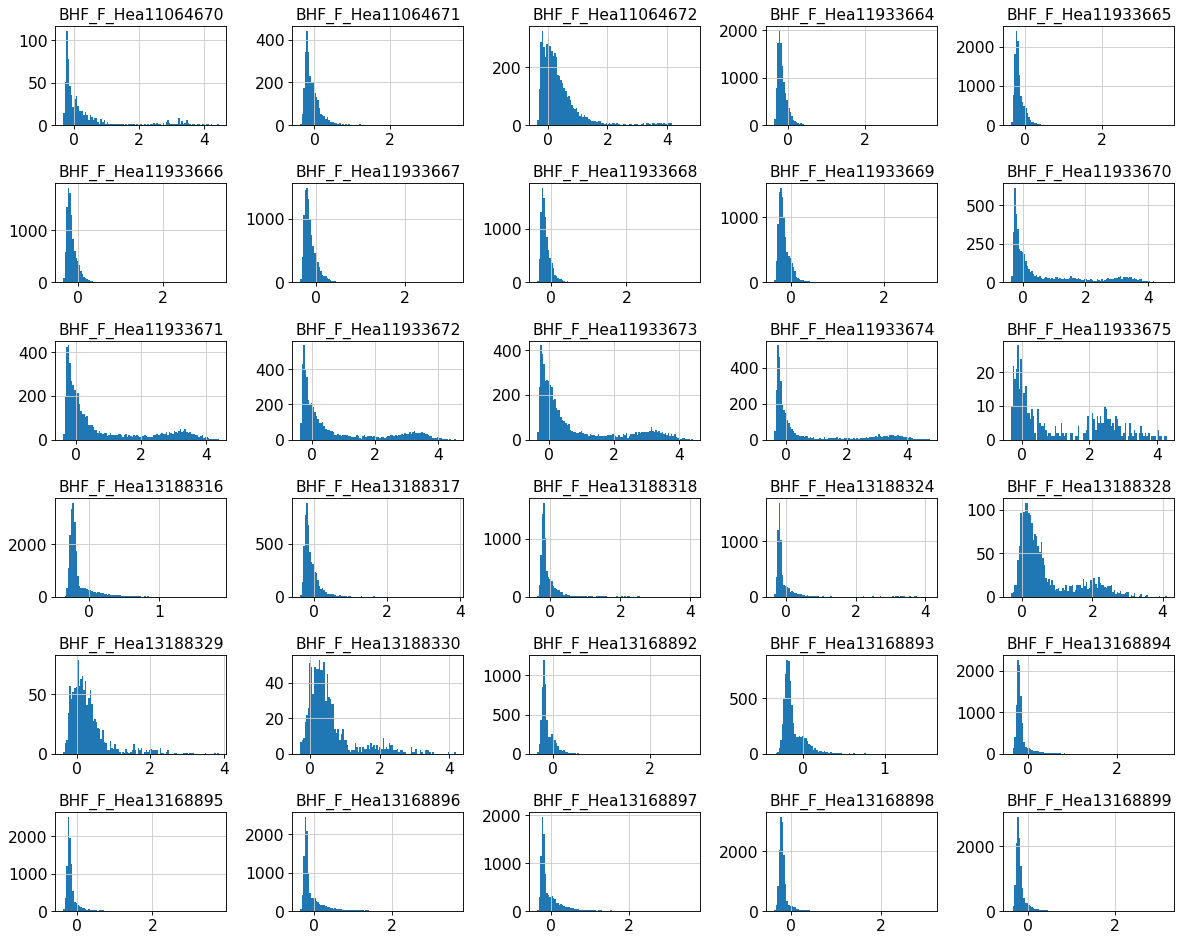

In [23]:
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

fig,axs=plt.subplots(nrows=6,ncols=5,figsize=(15,12))

for i,ID in enumerate(adata_c.obs['sangerID'].unique()):
    sample = adata_c[adata_c.obs['sangerID']==ID]
    axs[i//5,i%5].hist(sample.obs['HB_score'],bins=100)
    axs[i//5,i%5].set_title(ID)

fig.tight_layout()
plt.show()

In [24]:
# add HB score to original adata
adata.obs.loc[adata_c.obs_names,'HB_score']=adata_c.obs['HB_score']

## Remove RBCs

In [25]:
HBscore_thresh=1

adata=adata[adata.obs['HB_score']<HBscore_thresh]
adata.obs['sangerID'].value_counts()

BHF_F_Hea13188316    21522
BHF_F_Hea13168898    13897
BHF_F_Hea13168899    12371
BHF_F_Hea11933665    11830
BHF_F_Hea13168896    11209
BHF_F_Hea11933664    11024
BHF_F_Hea11933666    10463
BHF_F_Hea11933667    10342
BHF_F_Hea13168894     9997
BHF_F_Hea11933669     9539
BHF_F_Hea11933668     9491
BHF_F_Hea13168895     9433
BHF_F_Hea13168897     9325
BHF_F_Hea13188318     7475
BHF_F_Hea13168893     6745
BHF_F_Hea13188324     6269
BHF_F_Hea13168892     5650
BHF_F_Hea13188317     5208
BHF_F_Hea11064672     4521
BHF_F_Hea11933673     4188
BHF_F_Hea11933671     3873
BHF_F_Hea11933672     3870
BHF_F_Hea11933670     3505
BHF_F_Hea11064671     2809
BHF_F_Hea11933674     2780
BHF_F_Hea13188328     1492
BHF_F_Hea13188329     1090
BHF_F_Hea13188330      843
BHF_F_Hea11064670      613
BHF_F_Hea11933675      263
Name: sangerID, dtype: int64

In [26]:
# save
adata.write('/nfs/team205/heart/anndata_objects/Foetal/QC/multiome_RNA_foetal.h5ad')
adata

View of AnnData object with n_obs × n_vars = 211637 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-17', 'ambient_expression-18', 'ambient_expression-19', 'ambient_expression-2', '

In [27]:
pd.crosstab(adata.obs['donor'],adata.obs['age'])

age,GA-6w3d,GA-7w4d,GA-9w,GA-10w4d,GA-11w2d,GA-11w3d,PCW-13w,PCW-20w
donor,,,,,,,,
C82,0,0,0,0,0,613,0,0
C85,0,0,0,0,2809,0,0,0
C87,0,0,0,4521,0,0,0,0
C92,0,15436,0,0,0,0,0,0
C98,0,0,3043,0,0,0,0,0
C104,3425,0,0,0,0,0,0,0
Hst33,0,0,0,0,0,0,62689,0
Hst41,0,0,0,0,0,0,0,119101
